# Raw data load and imports

In [1]:
#basic libaries
import pandas as pd
import numpy as np
import re
import csv
from datetime import datetime

#visulization libaries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px


#warning libaries
import warnings
warnings.filterwarnings('ignore')

In [52]:
df=pd.read_csv('data.csv')
df.rename(lambda col: col.strip(), axis=1).rename(lambda col: col.lower(),axis=1)
df.rename(columns={'yr_built': 'year_built','yr_renovated':'year_renovated','statezip': 'state_zip'}, inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,year_built,year_renovated,street,city,state_zip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [28]:
def feature_data(df):
  """a methods that try to describe the data and put a first light spot on the data before start to clean it"""
  print(df.shape)

  table=pd.DataFrame(df.dtypes,columns=['type']).reset_index()
  table['features']=table['index']
  table=table[['features','type']]
  table['%nulls']=df.isnull().sum().values/len(df)
  table['nuniques']=df.nunique().values
  table['%uniques']=df.nunique().values/len(df)
  return table

feature_data(df)


(4600, 11)


,features,type,%nulls,nuniques,%uniques
0,price,float64,0.0,1741,0.378478
1,bedrooms,float64,0.0,10,0.002174
2,floors,float64,0.0,6,0.001304
3,waterfront,bool,0.0,2,0.000435
4,condition,int64,0.0,5,0.001087
5,city,object,0.0,44,0.009565
6,sqm_living,float64,0.0,566,0.123043
7,sqm_lot,float64,0.0,3113,0.676739
8,sqm_basement,float64,0.0,207,0.045000
9,house_old,int64,0.0,115,0.025000


# First Data Cleaning

In [4]:
def renovated_grouping(year):
  """builts strict groups from year_renovated fetures"""
  years_group=''

  if year==0:
    years_group='Never'

  elif year>=2000:
    years_group="2000's"

  elif year>=1990 and year<2000:
    years_group="90's"

  elif year>=1980 and year<1990:
    years_group="80's"

  elif year>=1970 and year<1980:
    years_group="70's"

  elif  year<1970:
    years_group="60's and Earlier"


  return years_group

In [53]:
#convert square feet to square meters as 1 sqaure feet is 1 sqm square meter
sqm=0.09290304
df['sqm_living']=df['sqft_living'].apply(lambda x: x*sqm)
df['sqm_lot']=df['sqft_lot'].apply(lambda x: x*sqm)
df['sqm_above']=df['sqft_above'].apply(lambda x: x*sqm)
df['sqm_basement']=df['sqft_basement'].apply(lambda x: x*sqm)


#discard from useless columns
df.drop(columns=['date','country','sqft_living','sqft_lot','sqft_above','sqft_basement',
                 'street','state_zip'],axis=1, inplace=True)

# EDA

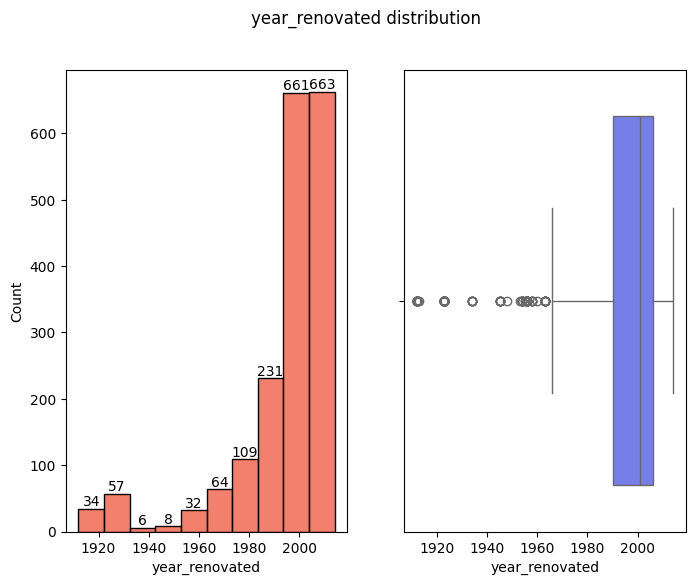

In [6]:
df_non_zero=df[df['year_renovated']>0]

#creates the figure and divide it to 2 different plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), dpi=100)

#make the actual plots
ax1=sns.histplot(data=df_non_zero, x='year_renovated', bins=10, ax=ax1,color='#EF553B')
ax1.bar_label(ax1.containers[0])
ax2=sns.boxplot(data=df_non_zero, x='year_renovated', ax=ax2, color='#636EFA')


plt.suptitle('year_renovated distribution')
plt.show()


#we can see that there are lots of outliers

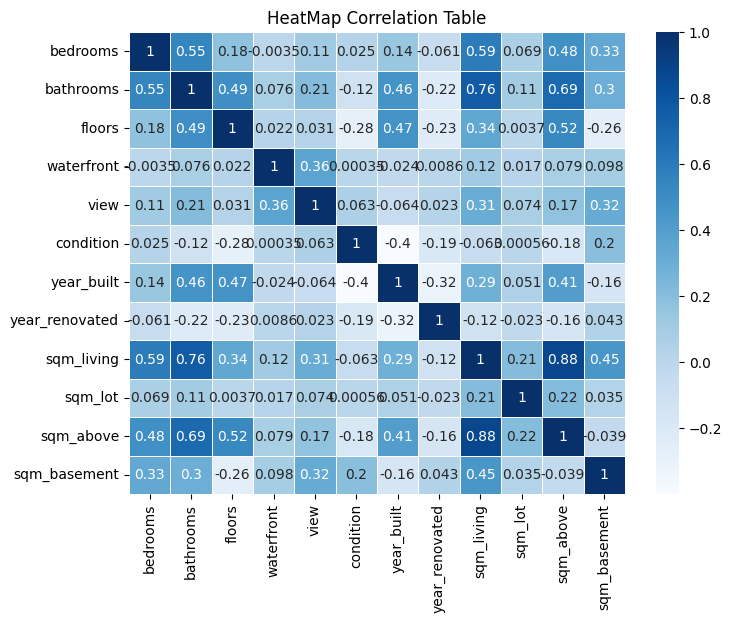

In [7]:
plt.figure(figsize=(8,6), dpi=100)
plt.title('HeatMap Correlation Table')
sns.heatmap(df.select_dtypes(np.number).drop(columns=['price']).corr(),annot=True,cmap='Blues',linewidth=0.7)
plt.show()

In [8]:
# lets see corr between featurs to see multicollinarty
correlation_matrix = df.select_dtypes(np.number).drop(columns=['price']).corr()
high_corr = correlation_matrix[(correlation_matrix >= 0.6) & (correlation_matrix !=1.0)]
high_corr = high_corr.stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr = high_corr.dropna()
high_corr

,Variable 1,Variable 2,Correlation
0,bathrooms,sqm_living,0.761154
1,bathrooms,sqm_above,0.689918
2,sqm_living,bathrooms,0.761154
3,sqm_living,sqm_above,0.876443
4,sqm_above,bathrooms,0.689918
5,sqm_above,sqm_living,0.876443


In [9]:
df[["sqm_above","sqm_living","bathrooms","price"]].corr()

,sqm_above,sqm_living,bathrooms,price
sqm_above,1.000000,0.876443,0.689918,0.36757
sqm_living,0.876443,1.000000,0.761154,0.43041
bathrooms,0.689918,0.761154,1.000000,0.32711
price,0.367570,0.430410,0.327110,1.00000


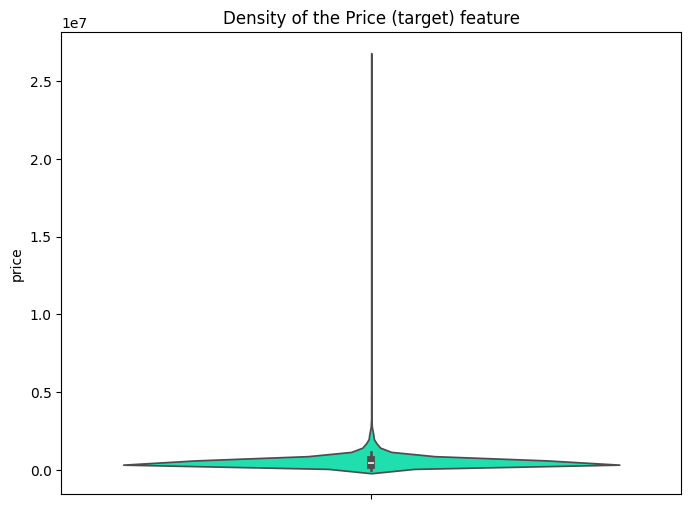

In [22]:
plt.figure(figsize=(8,6), dpi=100)
sns.violinplot(data=df, y='price',color='#00ffbf')
plt.title('Density of the Price (target) feature')
plt.show()

# Data Cleaning continues

In [54]:
# convert a binary feauture to boolean
df['waterfront']=df['waterfront'].astype(bool)
df['house_old']=df['year_built'].apply(lambda x: datetime.now().year-x)
df['renovation_group']=df['year_renovated'].apply(lambda y: renovated_grouping(y))
#df['new_view']=df['view'].apply(lambda x: True if x>0 else False)

#discard from useless columns
df.drop(columns=['year_built','year_renovated','sqm_above','view','bathrooms'],axis=1, inplace=True)
df.head()

,price,bedrooms,floors,waterfront,condition,city,sqm_living,sqm_lot,sqm_basement,house_old,renovation_group
0,313000.0,3.0,1.5,False,3,Shoreline,124.490074,735.048852,0.000000,69,2000's
1,2384000.0,5.0,2.0,False,5,Seattle,339.096096,840.772512,26.012851,103,Never
2,342000.0,3.0,1.0,False,4,Kent,179.302867,1109.912619,0.000000,58,Never
3,420000.0,3.0,1.0,False,4,Bellevue,185.806080,746.011411,92.903040,61,Never
4,550000.0,4.0,1.0,False,4,Redmond,180.231898,975.481920,74.322432,48,90's


# PreProccessing

In [51]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split as split,KFold,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error,mean_squared_error
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [12]:
X=df.drop(columns=['price'],axis=1)
y=df['price']
#split the data
X_train,X_test,y_train,y_test=split(X,y,shuffle=True,test_size=0.2,random_state=42)

In [13]:
class MyOneHotEncoder(BaseEstimator,TransformerMixin):
  def __init__(self):
    """constructor"""
    super().__init__()
    self.ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')

  def fit(self,X,y=None):
    """fit the non numric data on ohe object"""
    self.ohe.fit(X[['renovation_group','waterfront']])
    return self

  def transform(self, X):
    """after fitting the data we will transform what we learned and merge the numeric and the non numeric data into one df"""
    cat_data=pd.DataFrame(self.ohe.transform(X[['renovation_group','waterfront']]))
    numeric_data=X.select_dtypes(np.number)
    output=np.concatenate([cat_data,numeric_data],axis=1)

    return output



In [14]:
#create a pipeline
my_pipe=make_pipeline(MyOneHotEncoder(),StandardScaler())
X_train_model=my_pipe.fit_transform(X_train)
X_test_model=my_pipe.fit_transform(X_test)

X_train_model


array([[-0.56772709, -0.19059852, -0.13303802, ...,  0.87005417,
        -0.67958227, -0.62672137],
       [-0.56772709, -0.19059852, -0.13303802, ...,  0.40680186,
        -0.67958227, -0.6939252 ],
       [-0.56772709, -0.19059852, -0.13303802, ..., -0.09728842,
        -0.67958227, -0.39150796],
       ...,
       [-0.56772709,  5.24663052, -0.13303802, ..., -0.18096128,
        -0.33515114,  1.28858778],
       [ 1.76140969, -0.19059852, -0.13303802, ..., -0.35373518,
        -0.67958227,  2.36384905],
       [-0.56772709, -0.19059852, -0.13303802, ..., -0.3024627 ,
         0.6766153 ,  1.38939352]])

# Model

## XGBOOST

In [28]:
#initiate the model
my_xgb=XGBRegressor()

#set the hyperparameters
learning_rate=[0.01,0.05,0.1,0.25]
max_depth=[2,3,5,7,10]
n_estimators=[50,100]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[0.25,0.5,0.75,1]
min_samples_split=[3,5,7,10,20]
subsample=[0.5,0.8,1]

model_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'min_samples_split':min_samples_split,
            'max_features': max_features}


rand_model=RandomizedSearchCV(estimator=my_xgb,param_distributions=model_params,n_iter=5,scoring='neg_mean_squared_error',random_state=42)

In [29]:
rand_model.fit(X_train_model,y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=5,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [2, 3, 5, 7, 10],
                                        'max_features': [0.25, 0.5, 0.75, 1],
                                        'min_samples_split': [3, 5, 7, 10, 20],
                                        'n_estimators': [50, 100],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.8, 1]},
                   random_state=42, scoring='neg_mean_squared_error')

In [30]:
y_pred=rand_model.predict(X_test_model)

In [31]:
mean_absolute_error(y_pred=y_pred,y_true=y_test)

547513.4678825913

In [32]:
np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test))

1090109.0115045211

## Decision Tree

In [41]:
my_tree=DecisionTreeRegressor(random_state=42)

criterion=['absolute_error','squared_error']
max_depth=[3,5,7,10]
max_features=['sqrt','log2']
min_samples_split=[2,5,8,10]


tree_params={'criterion':criterion,
             'max_depth':max_depth,
             'max_features':max_features,
             'min_samples_split':min_samples_split}


grid_model=GridSearchCV(estimator=my_tree,param_grid=tree_params, scoring='neg_mean_squared_error',cv=4)

In [42]:
grid_model.fit(X_train_model,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 8, 10]},
             scoring='neg_mean_squared_error')

In [43]:
y_pred=grid_model.predict(X_test_model)

In [45]:
mean_absolute_error(y_pred=y_pred,y_true=y_test)

224891.1482873386

In [44]:
np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test))

996995.8484477616

## Linear Regression

In [34]:
linear_model=LinearRegression()
params={'fit_intercept':[True,False]}

scores = GridSearchCV(linear_model,params, scoring='neg_mean_squared_error', cv=5)

In [35]:
scores.fit(X_train_model,y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [36]:
y_pred=scores.predict(X_test_model)

In [39]:
mean_absolute_error(y_pred=y_pred,y_true=y_test)

2.324030699169687e+16

In [40]:
np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test))

5.315767182251707e+16

# Conclusions

The model who brings the most productive results is the **Descicion Tree** acording to the **MAE metric** which I chose to because of lots of outlier occasions on this dataset.
Because  those outliers were so far/different from the other data points and this dataset is quite small (only 4600 samples)  the model results were affected and made the MAE quite big.
to make it much smaller you may consider to get rid of some of the exterme outlier data point at the begining so the model could be much more precise

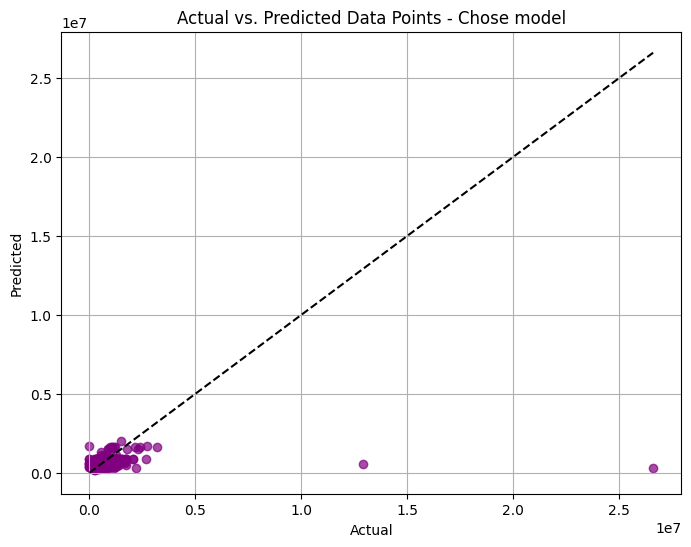

In [58]:
# as much as data points are close to the linear red strict line  the more points we are right to predict their prices
plt.figure(figsize=(8, 6),dpi=100)
plt.scatter(y_test, y_pred, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Data Points - Chose model')
plt.grid(True)
plt.show()